In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import scale, FunctionTransformer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.optimize import root
from itertools import combinations

In [2]:
prostate = pd.read_table("prostate.data", usecols = range(1,11), true_values = ["T"], false_values = ["F"])
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,True
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,True
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,True
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,True
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,True


In [14]:
X = scale(prostate.iloc[:, :-2])
y = prostate.iloc[:, -2]
X_train = X[prostate.train]
y_train = y[prostate.train]
X_test = X[~prostate.train]
y_test = y[~prostate.train]
N, p = X_train.shape
def test_error(model, X, y):
    return np.mean((model.predict(X) - y)**2)
def present_models(models, labels, is_subset = False):
    k = 10
    my_cv = KFold(n_splits=k, shuffle=True)
    cvs = [-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = my_cv) for model in models]
    means = np.array([np.mean(cv) for cv in cvs])
    ses = np.array([np.std(cv)/np.sqrt(k) for cv in cvs])
    threshold = np.min(means + ses)
    best_model_ix = np.argmax(means <= threshold)
    best_model = models[best_model_ix]
    best_model.fit(X_train, y_train)
    print("Test error:", test_error(best_model, X_test, y_test))
    if (is_subset):
        print("Subset:", best_model.best_estimator_.named_steps["subset"].kw_args["subset"])
        best_model = best_model.best_estimator_.named_steps["lr"]
    print(best_model.intercept_, best_model.coef_)
    plt.errorbar(range(p+1), means, yerr = ses, fmt = "orange", ecolor = "blue")
    plt.axhline(threshold, color = "violet", linestyle = "dashed")
    plt.axvline(best_model_ix, color = "violet", linestyle = "dashed")
    plt.axis([-0.2, 8.2 , np.min(means - ses)*0.8, np.max(means + ses)*1.2])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.suptitle(labels[2], fontsize=18)
    plt.show()

In [4]:
baseline = linear_model.LinearRegression()
baseline.fit(np.ones_like(y_train).reshape(-1,1), y_train)
test_error(baseline, np.ones_like(y_test).reshape(-1,1), y_test)

1.0567332280603821

In [5]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
print(linreg.intercept_, linreg.coef_)
test_error(linreg, X_test, y_test)

2.46493292212 [ 0.67601634  0.26169361 -0.14073374  0.20906052  0.30362332 -0.28700184
 -0.02119493  0.26557614]


0.52127400550760039

Test error: 0.492482347681
Subset: (0, 1)
2.47735734245 [ 0.73589083  0.31469341]


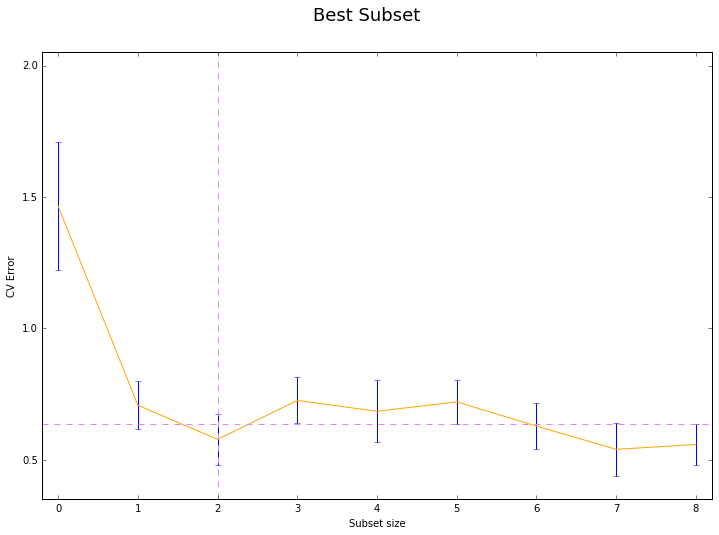

In [15]:
dumb_cv = [(slice(None), slice(None))]
pipe = Pipeline([("subset", FunctionTransformer(func = lambda X, subset: X[:, subset])), ("lr", linear_model.LinearRegression())])
subsets = [GridSearchCV(pipe, {"subset__kw_args": [{"subset": s} for s in combinations(range(p), i+1)]}, "neg_mean_squared_error", cv = dumb_cv) for i in range(p)]
subsets = [linear_model.Lasso(alpha = 1e10)] + subsets
present_models(subsets, ["Subset size", "CV Error", "Best Subset"], is_subset = True)

Test error: 0.490481454256
2.46413595207 [ 0.41787768  0.2373323  -0.04739153  0.16121026  0.22562815  0.00062589
  0.04097033  0.13150656]


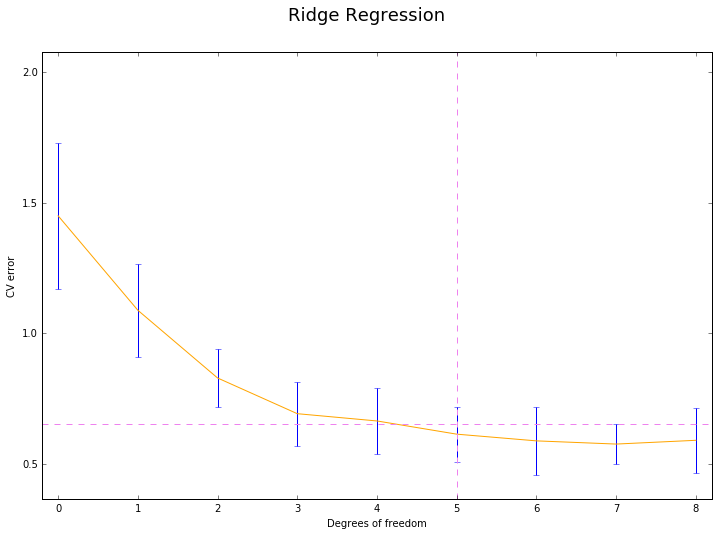

In [16]:
_, d, _ = np.linalg.svd(X_train)
alphas = [root(lambda a: np.sum((d **2) / (d ** 2 + a)) - i, x0 = 1).x[0] for i in range(p+1)]
ridge = [linear_model.Ridge(alpha = a) for a in alphas]
present_models(ridge, ["Degrees of freedom", "CV error", "Ridge Regression"])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test error: 0.452614026532
2.46544610451 [ 0.545184    0.21603509 -0.          0.09553368  0.16118889  0.          0.
  0.06450856]


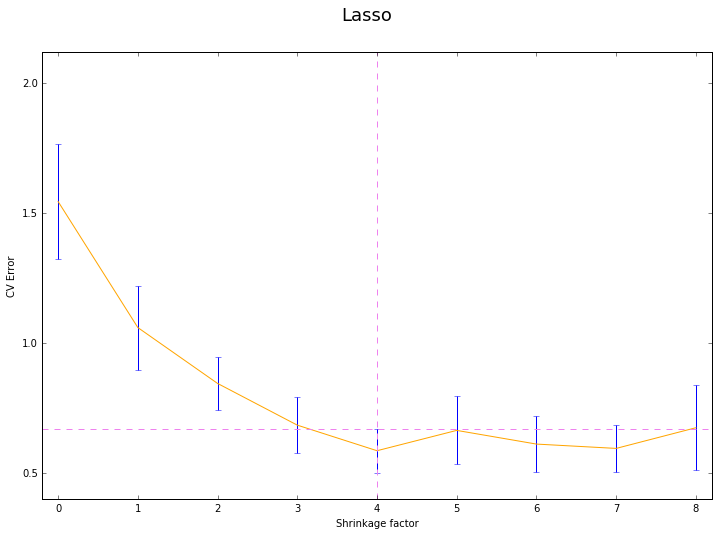

In [18]:
t_0 = np.sum(np.abs(linreg.coef_))
ts = np.linspace(0, t_0, p+1)[1:-1]
guesses = np.linspace(0.6, 0.01, p-1)
alphas = [root(lambda a: np.sum(np.abs(linear_model.Lasso(alpha = a).fit(X_train, y_train).coef_)) - t, x0 = guess).x[0] for t, guess in zip(ts, guesses)]
lasso = [linear_model.Lasso(alpha = a) for a in alphas]
lasso = [linear_model.Lasso(alpha = 1e10)] + lasso + [linear_model.LinearRegression()]
present_models(lasso, ["Shrinkage factor", "CV Error", "Lasso"])